### Sampling from a GP in 2D

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, vmap, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
def get_gaussianRBF(gamma):
    """
        Builds an RBF kernel function.

        Args:
            gamma (double): Length scale of the RBF kernel.

        Returns:
            function: This function returns the RBF kernel with fixed parameter gamma.   


        Example:
            >>> gamma1 = 1.
            >>> k = get_gaussianRBF(gamma1)
            >>> k(1.,2.)
            Array(0.60653066, dtype=float64)
            >>> gamma2 = 2.
            >>> k = get_gaussianRBF(gamma2)
            >>> k_vectorized = vectorize_kfunc(k)
            >>> x = jnp.array([1.,2.,3.])
            >>> y = jnp.array([4.,5.])
            >>> k(x,y)
            Array([[0.32465247, 0.13533528],
                   [0.60653066, 0.32465247],
                   [0.8824969 , 0.60653066]], dtype=float64)           
    """
    def k(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/(2*gamma**2))
    return k

In [3]:
def vectorize_kfunc(k):
    return jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))

### 1D

In [4]:
def GPsampler1D(num_samples, X, kernel, len_scale, reg, seed):
  '''
  nsamples: Number of samples.
  kernel: Covariance function.
  kparams: List of parameters of kernel.
  reg: Regularization for kernel matrix.
  X: Domain to get the sample.
  seed: Seed to reproduce the experiment.
  '''
  N = len(X)
  # Choose kernel
  if kernel == 'rbf':
    k = get_gaussianRBF(len_scale)
    k = vectorize_kfunc(k)
  # Build kernel matrix
  kernel_matrix = k(X,X) + reg*jnp.eye(N)
  chol_factor = jnp.linalg.cholesky(kernel_matrix)
  PRNG_key = jax.random.PRNGKey(seed)
  normal_samples = jax.random.normal(key = PRNG_key, shape=(N,num_samples))
  get_sample = jnp.dot(chol_factor,normal_samples)
  return get_sample

In [5]:
# Create fine grid
xtrain = jnp.linspace(0,1,100)

In [6]:
gp_out = GPsampler1D(num_samples = 5, X = xtrain, kernel = 'rbf', len_scale = 0.4, reg = 1e-5, seed = 2023)

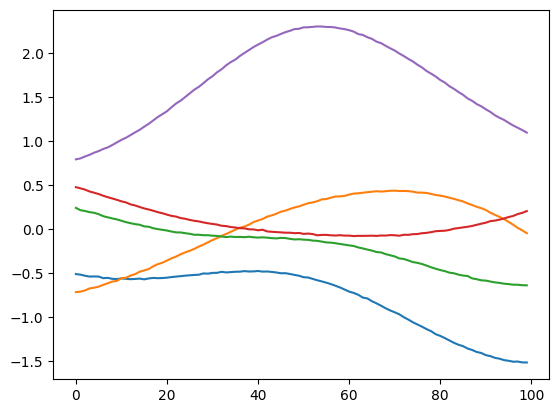

In [7]:
for i in range(5):
  plt.plot(gp_out[:,i])

### 2D

In [14]:
def GP_sampler(num_samples, X, kernel, len_scale, reg, seed):   
    """
        Gets samples(functions) of GP. 

        Args:
            num_samples (int): Number of samples.
            X (jnp.array): Domain to get the sample.
            kernel (str): Name of kernel.
            len_scale (float): Scale to be used in kernel.
            reg (float): Regularization to invert kernel matrix.
            seed (float): Integer to fix the simulation.

        Returns:
            list: Returns the list of functions sampled from the GP.   


        Example:
            >>> gamma1 = 1.
            >>> k = get_gaussianRBF(gamma1)
            >>> k(1.,2.)
            Array(0.60653066, dtype=float64)          
    """
    N = len(X)
    # Choose kernel
    if kernel == 'rbf':
      k = get_gaussianRBF(len_scale)
      k = vectorize_kfunc(k)
    # Build kernel matrix
    kernel_matrix = k(X,X) + reg*jnp.eye(N)
    chol_factor = jnp.linalg.cholesky(kernel_matrix)
    PRNG_key = jax.random.PRNGKey(seed)
    # Sample standard normal
    normal_samples = jax.random.normal(key = PRNG_key, shape=(N,num_samples))
    # Compute sample
    sample = jnp.dot(chol_factor,normal_samples)
    # Build interpolants
    def get_interpolant(pairs,values):
      coeffs = jnp.linalg.solve(kernel_matrix,values)
      def interp(x):
        return jnp.dot(k(x,X),coeffs)
      return interp
    
    interps = []
    for i in range(num_samples):
      interps.append(get_interpolant(X,sample[:,i]))
    
    return interps

In [15]:
# Create fine grid
x = jnp.linspace(0,1,40)
y = x
xv, yv = jnp.meshgrid(x, y)
pairs = jnp.vstack([xv.ravel(), yv.ravel()]).T

In [20]:
num_samples = 3
len_scale = 1
reg = 1e-12
gp_out = GP_sampler(num_samples = num_samples,
                      X = pairs, kernel = 'rbf',
                        len_scale = len_scale, 
                        reg = reg,
                          seed = 2025)

In [21]:
gp_out

[<function __main__.GP_sampler.<locals>.get_interpolant.<locals>.interp(x)>,
 <function __main__.GP_sampler.<locals>.get_interpolant.<locals>.interp(x)>,
 <function __main__.GP_sampler.<locals>.get_interpolant.<locals>.interp(x)>]

In [22]:
u1, u2, u3 = GP_sampler(num_samples = num_samples,
                      X = pairs, kernel = 'rbf',
                        len_scale = len_scale, 
                        reg = reg,
                          seed = 2025)

In [23]:
u1(pairs)

Array([-0.81486408, -0.80513906, -0.79336064, ...,  1.33616814,
        1.35864323,  1.38001376], dtype=float64)

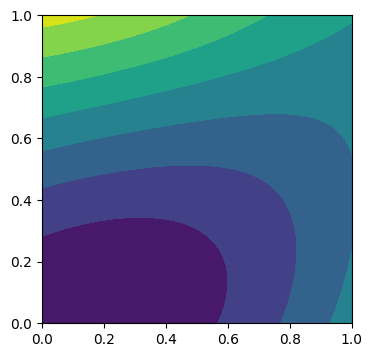

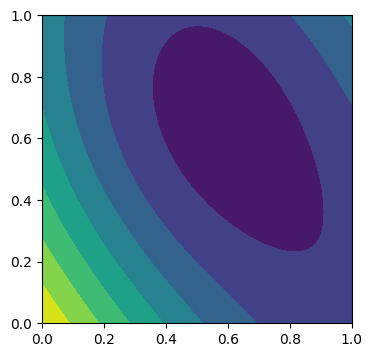

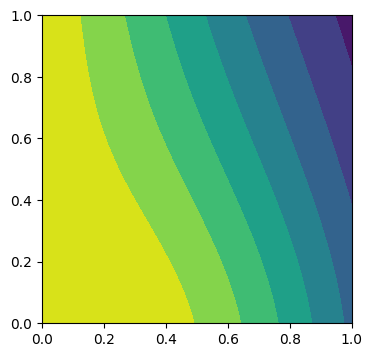

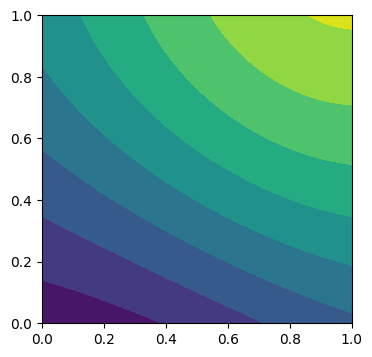

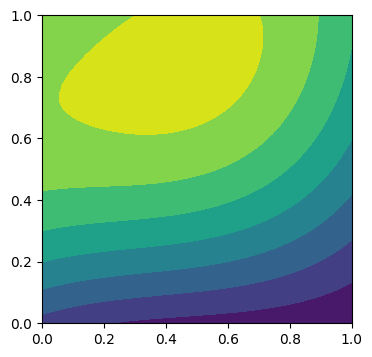

In [18]:
for i in range(5):
    plt.figure(figsize=(4,4))
    ui = gp_out[i]
    plt.tricontourf(pairs[:,0],pairs[:,1], ui(pairs))
    plt.show()

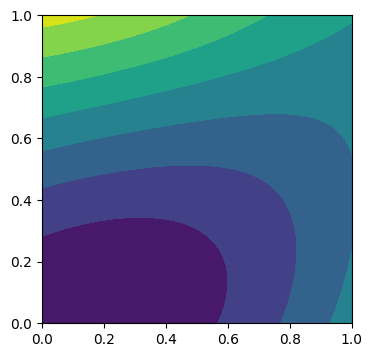

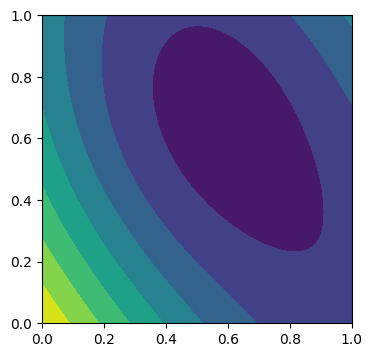

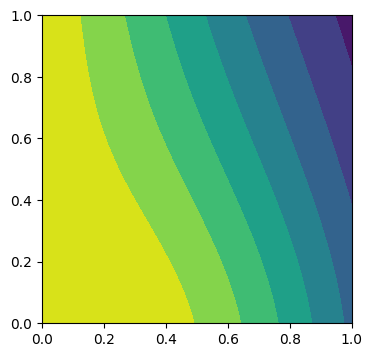

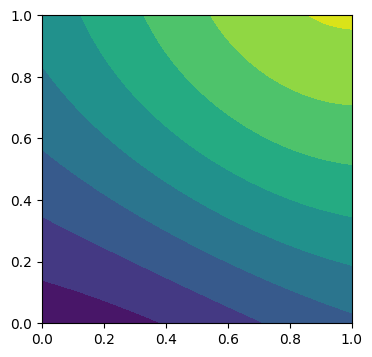

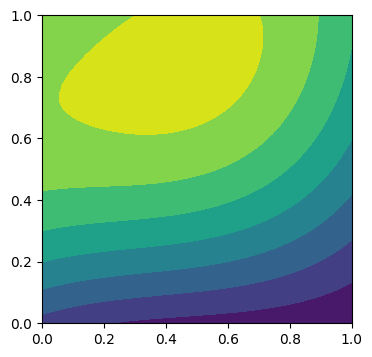

In [29]:
for i in range(5):
    plt.figure(figsize=(4,4))
    plt.tricontourf(pairs[:,0],pairs[:,1],gp_out[:,i])
    plt.show()